In [1]:
%load_ext autoreload
%autoreload 2
from fastai.vision import *
from fastai.vision.all import *
from fastai.distributed import *
from fastai.data import load
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress

from fastai.data.external import untar_data,URLs

from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
import torchvision.transforms as T
import torch
from torch.nn.parallel import DistributedDataParallel

from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision.models import resnet50, resnet101

import argparse
from models.utils.joiner_v4 import *
from models.utils.new_losses import *
from models.utils.metrics import Accuracy, Curating_Of_Attention_Loss
from models.utils.dataLoader import *
from models.utils.datasets import *
#import webdataset as wds
%reload_ext autoreload

In [6]:
path = untar_data(URLs.FLOWERS)
Path.BASE_PATH = path
path.ls()

(#4) [Path('valid.txt'),Path('test.txt'),Path('jpg'),Path('train.txt')]

In [7]:
#!pip install tree

In [8]:
!tree -d {path}

/bin/bash: tree: command not found


In [9]:
files = get_image_files(path/'jpg')
files

(#8189) [Path('jpg/image_03071.jpg'),Path('jpg/image_07844.jpg'),Path('jpg/image_06011.jpg'),Path('jpg/image_07900.jpg'),Path('jpg/image_04669.jpg'),Path('jpg/image_02092.jpg'),Path('jpg/image_06671.jpg'),Path('jpg/image_06209.jpg'),Path('jpg/image_00097.jpg'),Path('jpg/image_02333.jpg')...]

<AxesSubplot:>

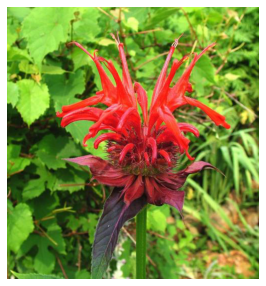

In [10]:
img = PILImage.create(files[0])
img.show()

In [12]:
train = pd.read_csv(path/'train.txt', header=None, sep=' ')
cols = ['name', 'label']
train.columns = cols
train.head()

,name,label
0,jpg/image_03860.jpg,16
1,jpg/image_06092.jpg,13
2,jpg/image_02400.jpg,42
3,jpg/image_02852.jpg,55
4,jpg/image_07710.jpg,96


In [13]:
valid = pd.read_csv(path/'valid.txt', sep=" ", names= cols )
# test df
test = pd.read_csv(path/'test.txt', sep=" ", names= cols )

In [16]:
print(f"The number of images in training set are:{len(train)}")
print(f"The number of images in validation set are:{len(valid)}")
print(f"The number of images in test set are:{len(test)}")

The number of images in training set are:1020
The number of images in validation set are:1020
The number of images in test set are:6149


In [17]:
df = pd.concat([train, valid, test], axis=0)
len(df)

8189

In [18]:
df.to_csv('data/flowers.csv')

In [23]:
labels = pd.read_csv('data/flowers_labels.txt', header=None, names = ['labels'])
labels['labels'] = labels['labels'].apply(lambda x: x.replace("'", ""))
labels.head()

,labels
0,pink primrose
1,hard-leaved pocket orchid
2,canterbury bells
3,sweet pea
4,english marigold


In [24]:
labels_dict = dict(zip(list(range(len(labels))), labels['labels']))

In [25]:
df['class'] = df['label'].apply(lambda x: labels_dict[x])
df.head()

,name,label,class
0,jpg/image_03860.jpg,16,purple coneflower
1,jpg/image_06092.jpg,13,spear thistle
2,jpg/image_02400.jpg,42,sword lily
3,jpg/image_02852.jpg,55,bishop of llandaff
4,jpg/image_07710.jpg,96,mallow


In [4]:
#df.to_csv('data/flowers.csv')
df = pd.read_csv('data/flowers.csv')
df.head()

,Unnamed: 0,name,label,class
0,0,jpg/image_03860.jpg,16,purple coneflower
1,1,jpg/image_06092.jpg,13,spear thistle
2,2,jpg/image_02400.jpg,42,sword lily
3,3,jpg/image_02852.jpg,55,bishop of llandaff
4,4,jpg/image_07710.jpg,96,mallow


In [9]:
def get_x(r): return path/r['name']
def get_y(r): return r['class']

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x= get_x,
                   get_y= get_y, 
                   item_tfms = Resize(256))
dls = dblock.dataloaders(df, bs=100) 

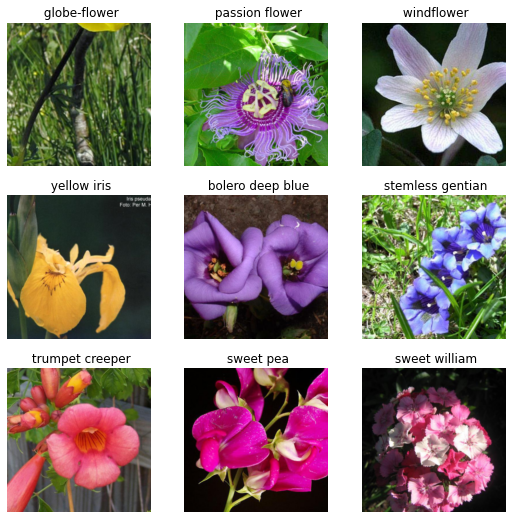

In [10]:
dls.show_batch()

In [62]:
fnames = get_image_files(data_path)
fnames[:5]

(#5) [Path('/home/atsumilab/.fastai/data/oxford-102-flowers/jpg/image_03071.jpg'),Path('/home/atsumilab/.fastai/data/oxford-102-flowers/jpg/image_07844.jpg'),Path('/home/atsumilab/.fastai/data/oxford-102-flowers/jpg/image_06011.jpg'),Path('/home/atsumilab/.fastai/data/oxford-102-flowers/jpg/image_07900.jpg'),Path('/home/atsumilab/.fastai/data/oxford-102-flowers/jpg/image_04669.jpg')]

In [10]:
sz = 256
bs = 64

In [42]:
def get_cat(r):
    a = attrgetter("name")
    rgex = RegexLabeller(pat = r'([^/]+)_\d+.jpg$') 
    return rgex(a(r))

dblock = DataBlock(blocks    = (ImageBlock, [RegressionBlock, CategoryBlock]),
                   n_inp=1,
                   get_items = get_image_files,
                   #get_y     = parent_label,
                   get_y     = get_cat,                   
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(256),
                   batch_tfms= Normalize.from_stats(*imagenet_stats)
                   #batch_tfms= transform
                  )
# dsets = dblock.datasets(path/"images")
#dsets = dblock.datasets(data_path)
dls = dblock.dataloaders(data_path/"images", bs=bs)

In [43]:
dsets[890]

(PILImage mode=RGB size=300x187, 'yorkshire_terrier')

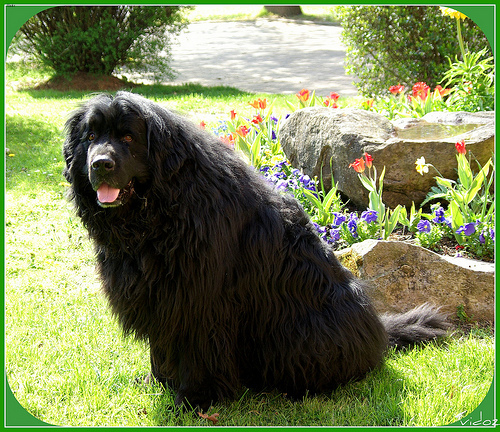

In [60]:
dls.train_ds[10][0]